[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Arif-PhyChem/MLQD/blob/main/Jupyter_Notebooks/KRR_SB.ipynb)

In [1]:
#Install MLQD along with its dependencies
!pip install mlqd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 9.5 MB/s eta 0:00:00


In [2]:
import numpy as np
from mlqd.evolution import quant_dyn
import matplotlib.pyplot as plt

We consider the two-state spin-boson model as was considered in our published study https://iopscience.iop.org/article/10.1088/1367-2630/ac3261

\begin{align} \label{eq:sb}
    \boldsymbol{\rm H} = \frac{1}{2}\epsilon \boldsymbol{\sigma}_{z}  + \frac{1}{2}\Delta \boldsymbol{\sigma}_{x} + \sum_{k} \omega_k \boldsymbol{\rm b}_k^\dagger \boldsymbol{\rm b}_k + \frac{1}{2} \boldsymbol{\sigma}_z \boldsymbol{\rm F},
\end{align}
here $\boldsymbol{\sigma}_z$ and $\boldsymbol{\sigma}_x$ are the Pauli matrices, i.e., $\boldsymbol{\sigma}_z = | e\rangle \langle e| - | g \rangle \langle g|$, $\boldsymbol{\sigma}_x =  |e\rangle \langle g| + | g \rangle \langle  e|$. $\epsilon$ and $\Delta$ are the energy bias and tunneling matrix element, respectively. $\omega_k$ is the frequency corresponds to $k$ bath mode and $\boldsymbol{\rm b}_k^\dagger$ is the corresponding bath creation operator. $\boldsymbol{\rm F}$ is the interaction operator and can be expressed as $\boldsymbol{\rm F} = \sum_k \frac{c_k}{\sqrt{2 \omega_k}} (\boldsymbol{\rm b}_k + \boldsymbol{\rm b}_k^\dagger)$, where $c_k$ denotes the coupling strength between system and $k$ bath mode. Initially, we consider that the system is in the excited state $|e\rangle$ (by absorbing a photon of energy equal to the energy gap between the two states) and we let the system to be relaxed by exchanging its energy with the bath.  

## Recursive dynamics 

In recursive dynamics, the future dynamics depends on the past dynamics 

$$ \rho(t_n) = f(t_{n-1}) $$

In some traditional quantum dynamics methods such as stochastic equation of motion (SEOM) approach, the noise in long-time dynamics deteriorates the accuracy and a good convergence needs propagation of a large number of trajectories. 

What we can do is to train a kernel ridge regression (KRR) model where if we provide a short time dynamics, the model should be able to predict the dynamics beyond it. We demonstarte this on the two-state spin-boson (SB) model. We consider the Drude–Lorentz spectral density 
$$
    J_{\text{b}}(\omega)=2 \lambda \frac{\omega \gamma}{\omega^{2}+\gamma^{2}},
$$
with $\gamma$ as characteristic frequency and $\lambda$ as the reorganization energy.

We use the Hierarchical equations of motion (HEOM) approach and generate data for all the possible combinations of the following parameters: $\epsilon = \{0, 1\}$, the reorganization energy $\lambda \in \{0.1$, $0.2$, $0.3$, $0.4$, $0.5$, $0.6$, $0.7$, $0.8$, $0.9$, $1.0 \},$ the characteristic frequency $\gamma \in \{1$, $2$, $3$, $4$, $5$, $6$, $7$, $8$, $9$, $10\},$ inverse temperature $\beta = 1/T \in \{0.1$, $0.25$, $0.5$, $0.75$, $1\}$. It should be noted that all parameters are in atomic units (a.u.). 

We generate 500 trajectories for each case (symmetric and asymmetric $\epsilon = \{0, 1\}$) and then train a KRR model on 400 trajectories (keeping 100 trajectories as a test set) for each case. You can grab the trajectories from our **QD3SET-1 database** https://doi.org/10.48550/arXiv.2301.12096. **However, here for the sake of demonstration, we provide 20 trajectories in the ```sb_data``` folder.**

## Preparation of the training data

Each trajectory is propagated for t= 20 (a.u.) with the time-step 0.05. For training, you can also use a larger time-step t = 0.1 to minize the cost of training. We take the intial dynamics of time-length $t_m$ from each trajectory and then use it as an input to predict the dynamics at the next time-step $t_{m+1}$. We include the dynamics at $t_{m+1}$ in the input short-time trajectory (dropping the value at $t_0$ to keep the length of the input the same) and then predict the dynamics at $t_{m+2}$. This process lasts till the last time-step.     

## User-Manual 

call ```quant_dyn``` with out passing any parameters

In [3]:
quant_dyn()

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., New Journal of Physics, 2021, 23(11), 113019
2) Ullah A. and Dral P. O., Nature Communic

# Training a KRR model  

### 1. With preparation of training data and optimization of the KRR model. MLQD is using MLatom package in the backend

Kernel ridge regression (KRR) model approximates a function $f( \boldsymbol{u})$ which is defined as
$$ 
    f(\boldsymbol{u}) = \sum_{i=1}^{N_{\rm tr}} \alpha_i k\left(  \boldsymbol{u}, \boldsymbol{u}_i\right),
$$
where $ \boldsymbol{\alpha} = \{\alpha_i\}$ is a vector of regression coefficients $\alpha_i$.

We use the Gaussian kernel here 

$$
    k\left(\boldsymbol{u}, \boldsymbol{u}_{i}\right)=\exp \left(-\frac{\left\|\boldsymbol{u}-\boldsymbol{u}_{i}\right\|_{2}^{2}}{2 \sigma^{2}}\right) .
$$
To train a KRR model, we use MLatom package (http://mlatom.com/) in the backend.

For the sake of demonstration, we provide 20 trajectories in the MLQD GitHub repo. The trajectories are in the ```Jupyter_Notebooks/sb_data``` folder. Here we take short trajectory of time-length $t_m = 4.0$ (a.u.) as an input-length. In MLQD, we pass it as ```'xlength': 81```.

In [ ]:
# Import the MLQD repo from GitHub
!git clone https://github.com/Arif-PhyChem/MLQD.git
!ls MLQD/Jupyter_Notebooks/sb_data

Cloning into 'MLQD'...
remote: Enumerating objects: 894, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 894 (delta 84), reused 55 (delta 30), pack-reused 724
Receiving objects: 100% (894/894), 34.91 MiB | 21.52 MiB/s, done.
Resolving deltas: 100% (376/376), done.
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.1.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.25.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.5.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.75.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-1.0.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.1.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.25.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.5.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.75.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-1.0.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-0.1.npy
2_epsilon-0.0_Del

In [ ]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : 'True',             # str: Prepare input files from the data (Default 'False')
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'dataPath': 'MLQD/Jupyter_Notebooks/sb_data' ,        # str: Data path
        'dataCol': 1,                   # int: Default is 1, we may have multiple columns in our data files, mention a single column (KRR model works only for single output)
        'dtype': 'real',                # str: Default is real. If the data in complex and if we pass 'real', it will prepare data only for real part and if we pass 'imag' is mentioned, only imaginary data will be considered. 
        'xlength': 81,                  # int:  Default is 81. Length of the short trajectory which will be used as an input
        'hyperParam': 'True',           # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C


### 2. With preparation of training data but No optimization of the KRR model. 


In [ ]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : 'True',           # str: Prepare input files from the data (Default 'False')
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'dataPath': 'MLQD/Jupyter_Notebooks/sb_data' ,        # str: Data path
        'dataCol': 1,                   # int: Default is 1, we may have multiple columns in our data files, mention a single column (KRR model works only for single output)
        'dtype': 'real',                # str: Default is real. If the data in complex and if we pass 'real', it will prepare data only for real part and if we pass 'imag' is mentioned, only imaginary data will be considered. 
        'xlength': 81,                  # int:  Default is 81. Length of the short trajectory which will be used as an input
        'hyperParam': 'False',          # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
        'krrSigma': 4.0,                # float: If we pass 'False' to hyperParam, then we need to provide a value for hyperparameter Sigma in Gaussian kernel. Otherwise the model will run with the default value. 
        'krrLamb': 0.00000001,          # float: If we pass 'False' to hyperParam, then we need to provide a value for hyper parameter Lambda in KRR. Otherwise the model will run with the default value.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

### 3. Without preparation of training data and optimization of the KRR model. 

In this example, we will not prepare the training data and will directly pass the X and Y files as were prepared in demonstration 1 or 2 

In [ ]:
param={ 
        'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'KRR',           # str: The type of model. Here KRR and the default option is OSTL
        'prepInput' : 'False',             # str: Prepare input files from the data (Default 'False')
        'XfileIn': 'x_train',           # str: (Optional, txt file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_train',           # str: (Optional, txt file) The prepared Y file will be saved at the provided file name
        'hyperParam': 'False',            # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
        'krrSigma': 4.0,                # float: If we pass 'False' to hyperParam, then we need to provide a value for hyperparameter Sigma in Gaussian kernel. Otherwise the model will run with the default value. 
        'krrLamb': 0.00000001,          # float: If we pass 'False' to hyperParam, then we need to provide a value for hyper parameter Lambda in KRR. Otherwise the model will run with the default value.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelOut': 'KRR_SB_model'    # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

# Propagating dynamics with the trained KRR model 

Lets propagate dynamics with the above trained KRR model trained on site-1 population. We provide a test file ```site_1_pop.txt``` in ```MLQD/Jupyter_Notebooks/test_set/sb/``` having an unseen short time trajectory (of the same length as was adopted during the training). We feed this short-time dynamics to the trained KRR model and we hope that it will predict the long dynamics. The short-time trajectoy is passed as a txt file. ***MLQD is also able to plot the dynamics against the reference trajectory***.

In [ ]:
param={ 
        'n_states': 2,                 # The number of states or sites
        'time': 20,                      # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation (you are restricted to the time-step used in the training data). Default for KRR is 0.05
        'QDmodel': 'useQDmodel',        # str: In MLQD, the dafault option is useQDmodel tells the MLQD to propagate dynamics with an existing trained model
        'QDmodelType': 'KRR',           # str: The type of model we wanna use (KRR, AIQD, or OSTL). Here KRR and the default option is OSTL
        'XfileIn': 'MLQD/Jupyter_Notebooks/test_set/sb/state_1_pop.txt',           # str: Name of a txt file where a short time trajectory (equal to the length the input-model was trained on) is saved. The data should be row wise.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelIn': 'KRR_SB_model',    # str: (Not optional for useQDmodel), provide the name of the trained ML model
        'QDtrajOut': 'KRR_trajectory',  # str: (Optional), File name where the trajectory should be saved
        'dataCol': 1,                   # We provide it grab the corresponding column from the reference trajectory
        'dtype': 'real',                # Grab the real of the column data
        'xlim': 20,                     # Xaxis limit for plotting. Default is equal to propagation time
        'pltNstates': 2,                # How many states to be plotted. Default option is to plot all
        'refTraj':'MLQD/Jupyter_Notebooks/test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy' # Reference trajectory 
 }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

Text(0.5, 1.0, 'Time evolution of the excited state \n population in the spin-boson model')

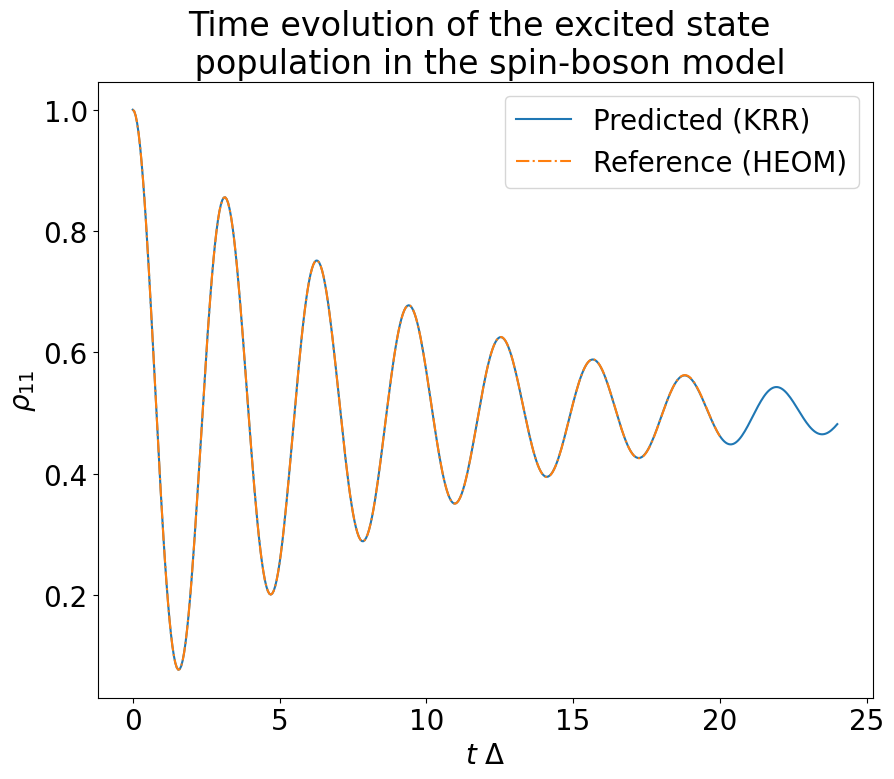

In [ ]:
heom_dyn = np.load('MLQD/Jupyter_Notebooks/test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy')
pred_dyn = np.load('KRR_trajectory.npy')
t_1 = np.real(heom_dyn[:,0])
t_2 = pred_dyn[:,0]
pred_state_1_pop = pred_dyn[:,1]
heom_state_1_pop = np.real(heom_dyn[:,1])

plt.rcParams['font.size'] = '20'
plt.figure(figsize=(10,8))
plt.plot(t_2, pred_state_1_pop, )
plt.plot(t_1, heom_state_1_pop, '-.')
plt.xlabel(r'$t \ \Delta$')
plt.ylabel(r'$\rho_{11}$')
plt.legend(["Predicted (KRR)", 'Reference (HEOM)'])
plt.title('Time evolution of the excited state \n population in the spin-boson model')

We can see that by providing a shot-time dynamics of 4 (a.u), the KRR model was able to predict the beyond dynamics and suprisingly, it could also extrapolate beyond the training region as shown by the blue region at the end. 